### Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchaudio
import torchaudio_augmentations as ta

import lightning as L
from lightning import LightningModule

import auraloss

import numpy as np
import math

import pandas as pd

from typing import Optional, Union

from tqdm import tqdm

import os


### Constants

In [2]:
DEFAULT_INPUT_SR = 16000
DEFAULT_LATENT_SR = 250 # Chosen because 16000 / 2^6 = 250, and we have an even number of 0.5x downsamples
DEFAULT_LATENT_CHANNELS = 32 # Seems to be a pretty standard value for this

DEFAULT_1D_KERNEL_SIZE = 7 # This seems to be standard practice for waveforms
DEFAULT_1D_PADDING = 3 # Padding necessary for kernel size 7 for exact halving of dimensions

DEFAULT_MAX_CHANNELS = 128

DEFAULT_AUDIO_DUR = 10 # In seconds

### Loss & Data

In [3]:
class ELBO_Loss(nn.Module):
    def __init__(self, kl_weight=1e-3, sample_rate: int=DEFAULT_INPUT_SR):
        super().__init__()
        self.stft_loss = auraloss.freq.MultiResolutionSTFTLoss(perceptual_weighting=True, sample_rate=sample_rate)
        self.kl_weight = kl_weight

    def forward(self, recon, real, mu, logvar):
        stft = self.stft_loss(recon, real)
        kl = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
        return stft + self.kl_weight * kl

# TODO: make this a proper pytorch module
def feature_matching_loss(real_feats, fake_feats):
    loss = 0
    for real, fake in zip(real_feats, fake_feats):
        loss += F.l1_loss(real, fake)
    return loss

In [ ]:
class FmaMediumDataset(Dataset):
    def __init__(self, root_dir, sample_rate=DEFAULT_INPUT_SR, duration=DEFAULT_AUDIO_DUR):
        """
        Args:
            root_dir (str): Path to the fma_medium directory.
            sample_rate (int): Target sample rate.
            duration (int): Duration of each sample in seconds.
        """
        self.sample_rate = sample_rate
        self.num_samples = sample_rate * duration
        self.audio_paths = []

        # Collect all MP3 files recursively
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith(".mp3"):
                    self.audio_paths.append(os.path.join(root, file))

        self.target_frames = sample_rate * duration
        self.crop = ta.RandomResizedCrop(self.target_frames)

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        path = self.audio_paths[idx]
        try:
            waveform, sr = torchaudio.load(path)
        except RuntimeError:
            # Cus theres a few malformed waveforms in fma medium, pray the collate function can handle this case
            return None
        # Convert to mono
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # Resample to target sample rate
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
            waveform = resampler(waveform)

        # Pad or crop to fixed number of samples
        if waveform.shape[1] < self.num_samples:
            pad_amt = self.num_samples - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, pad_amt))
        else:
            waveform = self.crop(waveform)

        return waveform

class MusicDataModule(L.LightningDataModule):
    def __init__(
        self,
        data_dir: str = "./",
        batch_size: int = 1,
        num_workers: int = 1,
        target_sr: int = 16000,
        clip_duration: float = DEFAULT_AUDIO_DUR,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.target_sr = target_sr
        self.clip_duration = clip_duration

    def setup(self, stage: Optional[str] = None):
        self.train_dataset = FmaMediumDataset(
            self.data_dir,
            self.target_sr,
            self.clip_duration
        )

    def _collate_fn(self, batch):
        clips = []
        for clip in batch:
            if clip is None:
                continue
            clips.append(clip)
        return torch.stack(clips)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, pin_memory=True, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, collate_fn=self._collate_fn
        )


### Model: Attention

In [5]:

def sinu_posn_embedding(max_len: int, dim: int) -> torch.Tensor:
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, dim, 2) * -(math.log(10000.0) / dim))
    pe = torch.zeros(max_len, dim)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

class SelfAttention(nn.Module):
    """
    Self attention with positional embedding
    """
    def __init__(self, channels: int, n_heads: int, max_len: Union[None, int] = DEFAULT_AUDIO_DUR * DEFAULT_LATENT_SR, permute=True):
        """
        Multiheaded self-attention (with residual connections)

        Args:
            channels (int): Channels for input sequence
            n_heads (int): Number of attention heads
            max_len: Max sequence length, if none, this module will not include positional embeddings
        """
        super().__init__()
        self.dim = channels
        self.attn = nn.MultiheadAttention(channels, n_heads, batch_first=True)
        self.permute = permute

        # Precompute positional encodings
        self.max_len = max_len
        if max_len is not None:
            pe = sinu_posn_embedding(max_len, channels)
            self.register_buffer('pe', pe.unsqueeze(0), persistent=False) # shape [1, max_len, channels]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for self-attention (with residual connections)

        B = batch
        C = channels
        T = time
        Args:
            x (torch.Tensor): Sequence tensor of shape [B, C, T]
            Could be shape [B, T, C] if permute = False

        Returns:
            torch.Tensor: Tensor of shape [B, C, T]
        """
        B, C, T = x.shape
        if self.permute:
            x = x.permute(0, 2, 1)  # Reshape to [B, T, C] (expected shape for attention)
        if self.max_len is not None:
            pos_emb = self.pe[:, :T, :] # self.register_buffer adds self.pe
            attn_in = x + pos_emb
        else:
            attn_in = x
        attn_out, _ = self.attn(attn_in, attn_in, attn_in, need_weights=False)
        out = (x + attn_out)
        if self.permute:
            out = out.permute(0, 2, 1)
        return out


### Model: VAE

In [6]:
class UpsampleLayer(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(UpsampleLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.upsample = nn.ConvTranspose1d(in_channels, out_channels, DEFAULT_1D_KERNEL_SIZE, stride=2, padding=DEFAULT_1D_PADDING, output_padding=1)
        self.conv = nn.Conv1d(out_channels, out_channels, DEFAULT_1D_KERNEL_SIZE, stride=1, padding=DEFAULT_1D_PADDING)
        self.norm = nn.GroupNorm(out_channels // 4, out_channels)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.upsample(x)
        x = self.activation(x)
        x = self.conv(x) + x
        x = self.norm(x)
        x = self.activation(x)
        return x

class DownsampleLayer(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(DownsampleLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = nn.Conv1d(in_channels, out_channels, DEFAULT_1D_KERNEL_SIZE, stride=2, padding=DEFAULT_1D_PADDING)
        self.norm = nn.GroupNorm(out_channels // 4, out_channels)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        return x

class VAE_Encoder(nn.Module):
    def __init__(self,
                 input_channels: int,
                 latent_channels: int=DEFAULT_LATENT_CHANNELS,
                 input_sr: int=DEFAULT_INPUT_SR,
                 latent_sr: int=DEFAULT_LATENT_SR,
                 audio_dur: int=DEFAULT_AUDIO_DUR):
        """
        Conditional Variational Autoencoder Encoder
        Args:
            input_channels (int): Number of channels for input audio waveforms (ex. stereo vs. mono)
            latent_channels (int): Number of channels for latent audio waveforms
            input_sr (int): Input audio waveform sample rate (16000Hz default)
            latent_sr (int): Target Latent audio sample rate (125Hz default) - No guarantees it'll actually reach this
        """
        super(VAE_Encoder, self).__init__()

        self.input_channels = input_channels
        self.latent_channels = latent_channels
        self.input_sr = input_sr
        self.latent_sr = latent_sr

        # Input dimension must be some power of 2 multiple of latent dim
        self.n_downsamples = np.ceil(np.log2(self.input_sr / self.latent_sr)).astype(np.int32)
        assert (2 ** self.n_downsamples) * latent_sr == self.input_sr

        starter_channels = 16
        layers = [
            nn.Conv1d(input_channels, starter_channels, DEFAULT_1D_KERNEL_SIZE, stride=1, padding=DEFAULT_1D_PADDING),
            nn.GELU(),
        ]

        # Channels go from 16 -> 32 -> 64 -> DEFAULT_MAX_CHANNELS ... n_downsamples layers
        in_ch = starter_channels
        for i in range(self.n_downsamples):
            out_ch = min(in_ch * 2, DEFAULT_MAX_CHANNELS)
            layers.append(DownsampleLayer(in_ch, out_ch))  # Downsample by factor of 2
            in_ch = out_ch
            layers.append(nn.Conv1d(in_ch, in_ch, DEFAULT_1D_KERNEL_SIZE, stride=1, padding=DEFAULT_1D_PADDING))
            layers.append(nn.GELU())

        layers.append(SelfAttention(in_ch, 4, audio_dur * self.latent_sr))

        self.layers = nn.Sequential(*layers)

        self.mu_proj = nn.Sequential(
            nn.Conv1d(in_ch, in_ch, kernel_size=DEFAULT_1D_KERNEL_SIZE, padding=DEFAULT_1D_PADDING),
            nn.GELU(),
            nn.Conv1d(in_ch, latent_channels, kernel_size=1)
        )

        self.logvar_proj = nn.Sequential(
            nn.Conv1d(in_ch, in_ch, kernel_size=DEFAULT_1D_KERNEL_SIZE, padding=DEFAULT_1D_PADDING),
            nn.GELU(),
            nn.Conv1d(in_ch, latent_channels, kernel_size=1)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        VAE encoder forward pass, input waveforms are expected to be of the correct sample rate (from VAE encoder constructor)

        B = batch size
        C = channels
        T = timesteps

        L = latent space channels
        T' = T * latent_sr / input_sr
        Args:
            x (torch.Tensor): Batch of waveforms of shape [B, C, T]
        Returns:
            Parameters to a diagonal Gaussian in latent space
            torch.Tensor: Latent space tensor of shape [B, L, T'] mean
            torch.Tensor: Latent space tensor of shape [B, L, T'] log variances
        """
        x = self.layers(x)
        return self.mu_proj(x), self.logvar_proj(x)

class VAE_Decoder(nn.Module):
    def __init__(self,
                 input_channels: int,
                 latent_channels: int=DEFAULT_LATENT_CHANNELS,
                 input_sr: int=DEFAULT_INPUT_SR,
                 latent_sr: int=DEFAULT_LATENT_SR,
                 audio_dur: int=DEFAULT_AUDIO_DUR):
        """
        Conditional Variational Autoencoder Decoder
        Args:
            input_channels (int): Number of channels for input audio waveforms (ex. stereo vs. mono)
            latent_channels (int): Number of channels for latent audio waveforms
            input_sr (int): Input audio waveform sample rate (16000Hz default)
            latent_sr (int): Target Latent audio sample rate (125Hz default) - No guarantees it'll actually reach this
        """
        super(VAE_Decoder, self).__init__()

        self.input_channels = input_channels
        self.latent_channels = latent_channels
        self.input_sr = input_sr
        self.latent_sr = latent_sr

        # Input dimensions must be some power of 2 multiple of latent dim
        self.n_upsamples = np.ceil(np.log2(self.input_sr / self.latent_sr)).astype(np.int32)
        assert (2 ** self.n_upsamples) * latent_sr == self.input_sr

        channels = DEFAULT_MAX_CHANNELS
        layers = [
            nn.Conv1d(latent_channels, channels, DEFAULT_1D_KERNEL_SIZE, stride=1, padding=DEFAULT_1D_PADDING),
            nn.GELU(),
        ]

        layers.append(SelfAttention(channels, 4, audio_dur * self.latent_sr))

        for i in range(self.n_upsamples):
            layers.append(UpsampleLayer(channels, channels))
            layers.append(nn.Conv1d(channels, channels, DEFAULT_1D_KERNEL_SIZE, stride=1, padding=DEFAULT_1D_PADDING))
            layers.append(nn.GELU())

        layers.append(nn.Conv1d(channels, input_channels, kernel_size=1))

        self.layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        VAE decoder forward pass, input latent space waveforms and outputs waveforms in original input space

        B = batch size
        Z = latent channels
        T = timesteps
        Args:
            x (torch.Tensor): Batch of latent waveforms of shape [B, Z, T']

        Returns:
            torch.Tensor: Reconstruction of waveforms in input space of shape [B, C, T]
        """
        return self.layers(x)

class VAE(nn.Module):
    def __init__(self, audio_channels: int, input_sr: int=DEFAULT_INPUT_SR, audio_dur: int = DEFAULT_AUDIO_DUR):
        super(VAE, self).__init__()
        self.channels = audio_channels
        self.input_sr = input_sr
        self.encoder = VAE_Encoder(audio_channels, input_sr=DEFAULT_INPUT_SR, audio_dur=audio_dur)
        self.decoder = VAE_Decoder(audio_channels, input_sr=DEFAULT_INPUT_SR, audio_dur=audio_dur)
        self.latent_dim = self.decoder.latent_channels
        self.latent_sr = self.decoder.latent_sr

    def _sample(self, mu: torch.Tensor, log_var: torch.Tensor):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def generate(self, n_samples: int=1, dur: int = DEFAULT_AUDIO_DUR) -> torch.Tensor:
        z = torch.randn([n_samples, self.latent_dim, self.latent_sr * dur]).to(device='cuda:0')
        audio = self.decoder(z)
        return audio

    def forward(self, input: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Full VAE encoder + decoder forward pass

        Args:
            x (torch.Tensor): Batch of waveforms of shape [B, C, T]

        Returns:
            torch.Tensor: Reconstruction of waveforms in input space of shape [B, C, T]
            torch.Tensor: Mean of Gaussian distribution over latent space
            torch.Tensor: Log variance of Gaussian distribution over latent space

        """
        mu, log_var = self.encoder(input)
        sample = self._sample(mu, log_var)
        reconstruction = self.decoder(sample)
        return reconstruction, mu, log_var

# Unused now
class AudioVAE(LightningModule):
    def __init__(self, channels: int, kl_weight: float = 1e-3, lr=1e-4):
        super(AudioVAE, self).__init__()
        self.vae = VAE(channels)
        self.loss = ELBO_Loss(kl_weight)
        self.lr = lr

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.vae(x)

    def training_step(self, batch, batch_idx=None, dataloader_idx=None) -> torch.Tensor:
        reconstruction, mu, log_var = self.vae(batch)
        loss = self.loss(reconstruction, batch, mu, log_var)
        self.log('training_elbo_loss', loss, prog_bar=True)
        return loss

    def generate(self, n_samples: int):
        return self.vae.generate(n_samples)

    def configure_optimizers(self):
        return optim.Adam(self.vae.parameters(), self.lr)


In [7]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_channels: int):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv1d(input_channels, 128, 15, stride=1, padding=7),   # preserves resolution
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 128, 41, stride=4, padding=20, groups=4),   # grouped conv like HiFi-GAN
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 128, 41, stride=4, padding=20, groups=16),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 128, 41, stride=4, padding=20, groups=16),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 128, 41, stride=4, padding=20, groups=16),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 128, 5, stride=1, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 1, kernel_size=3, stride=1, padding=1)     # patch discriminator output
        ])

    def forward(self, x, return_features=False):
        features = []
        for layer in self.layers:
            x = layer(x)
            features.append(x)
        return (x, features) if return_features else x

class AudioVAEGAN(LightningModule):
    """
    Heavily inspired by https://arxiv.org/pdf/2404.10301v2
    """
    def __init__(self, channels: int, kl_weight: float = 1e-3, adv_weight: float = 1.0, lr: float=1e-4, discriminator_pause: int=0, sample_rate=DEFAULT_INPUT_SR, audio_dur: int = DEFAULT_AUDIO_DUR):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.automatic_optimization = False # We define the optimization routine in training_step() instead of using lightning's automatic one

        self.vae = VAE(channels, audio_dur=audio_dur)
        self.discriminator = PatchDiscriminator(channels)

        self.recon_loss = ELBO_Loss(kl_weight, sample_rate)
        self.adv_weight = adv_weight
        self.discriminator_pause = discriminator_pause

    def forward(self, x):
        return self.vae(x)

    # # Cross entropy adversarial loss, I found hinge loss to perform better
    # def adversarial_loss(self, pred, target_is_real=True):
    #     target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
    #     return F.binary_cross_entropy_with_logits(pred, target)

    # Hinge adversarial loss
    def adversarial_loss(self, pred, target_is_real=True):
        if target_is_real:
            return torch.mean(F.relu(1.0 - pred))
        else:
            return torch.mean(F.relu(1.0 + pred))

    def training_step(self, batch, batch_idx):
        real = batch
        opt_vae, opt_disc = self.optimizers()

        # === Train Generator ===
        self.toggle_optimizer(opt_vae)
        recon, mu, logvar = self.vae(real)

        elbo = self.recon_loss(recon, real, mu, logvar)

        d_fake, fake_feats = self.discriminator(recon, return_features=True)
        _, real_feats = self.discriminator(real, return_features=True)

        adv_loss = self.adversarial_loss(d_fake, True)
        fm_loss = feature_matching_loss(real_feats, fake_feats)

        total_gen_loss = elbo + self.adv_weight * adv_loss + fm_loss

        self.manual_backward(total_gen_loss)
        torch.nn.utils.clip_grad_norm_(self.vae.parameters(), max_norm=1.0)
        opt_vae.step()
        opt_vae.zero_grad()
        self.untoggle_optimizer(opt_vae)

        # === Train Discriminator ===
        self.toggle_optimizer(opt_disc)
        recon_detached = recon.detach()

        d_real = self.discriminator(real)
        d_fake = self.discriminator(recon_detached)

        real_loss = self.adversarial_loss(d_real, True)
        fake_loss = self.adversarial_loss(d_fake, False)
        d_loss = 0.5 * (real_loss + fake_loss)

        # Discriminator's prety strong, let the generator have some fun
        if self.discriminator_pause != 0 and batch_idx % self.discriminator_pause == 0:
            opt_disc.zero_grad()
            self.log_dict({
                "gen/elbo": elbo,
                "gen/adv": adv_loss,
                "gen/fm": fm_loss,
                "gen/total": total_gen_loss,
                "disc/loss": d_loss,
            }, prog_bar=True, on_step=True, on_epoch=True)
            self.untoggle_optimizer(opt_disc)
            return

        self.manual_backward(d_loss)
        torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), max_norm=1.0)
        opt_disc.step()
        opt_disc.zero_grad()
        self.untoggle_optimizer(opt_disc)

        # === Logging ===
        self.log_dict({
            "gen/elbo": elbo,
            "gen/adv": adv_loss,
            "gen/fm": fm_loss,
            "gen/total": total_gen_loss,
            "disc/loss": d_loss,
        }, prog_bar=True, on_step=True, on_epoch=True)

    @torch.no_grad()
    def generate(self, n_samples: int, dur: int = DEFAULT_AUDIO_DUR):
        """
        This is kinda shit - the Gaussian prior on the latent space is a little too weak
        """
        return self.vae.generate(n_samples, dur)

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.vae.parameters(), lr=self.lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr * 2)
        return [opt_g, opt_d]


### Model: LDM

In [8]:
class GaussianDiffusion:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.timesteps = timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.0]), self.alpha_cumprod[:-1]], dim=0)

        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alpha_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.posterior_variance = self.betas * (1.0 - self.alpha_cumprod_prev) / (1.0 - self.alpha_cumprod)

    def to(self, device):
        for name in dir(self):
            attr = getattr(self, name)
            if isinstance(attr, torch.Tensor):
                setattr(self, name, attr.to(device))

    def q_sample(self, x_start, t, noise=None):
        self.to(x_start.device)
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alpha_cumprod_t = self._extract(self.sqrt_alpha_cumprod, t, x_start.shape)
        sqrt_one_minus_alpha_cumprod_t = self._extract(self.sqrt_one_minus_alpha_cumprod, t, x_start.shape)

        return sqrt_alpha_cumprod_t * x_start + sqrt_one_minus_alpha_cumprod_t * noise

    def p_losses(self, model, x_start, t):
        self.to(x_start.device)
        noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start, t, noise)
        predicted_noise = model(x_noisy, t)
        return F.mse_loss(predicted_noise, noise)

    @torch.no_grad()
    def sample(self, model, shape, device):
        self.to(device)
        x = torch.randn(shape, device=device)

        for i in tqdm(reversed(range(self.timesteps)), total=self.timesteps):
            t = torch.full((shape[0],), i, device=device, dtype=torch.long)

            betas_t = self._extract(self.betas, t, x.shape)
            sqrt_recip_alphas_t = self._extract(self.sqrt_recip_alphas, t, x.shape)
            sqrt_one_minus_alpha_cumprod_t = self._extract(self.sqrt_one_minus_alpha_cumprod, t, x.shape)

            model_mean = sqrt_recip_alphas_t * (
                x - betas_t * model(x, t) / sqrt_one_minus_alpha_cumprod_t
            )

            if i > 0:
                posterior_variance_t = self._extract(self.posterior_variance, t, x.shape)
                noise = torch.randn_like(x)
                x = model_mean + torch.sqrt(posterior_variance_t) * noise
            else:
                x = model_mean

        return x

    def _extract(self, a, t, x_shape):
        """Extract values from 1-D tensor `a` at positions `t` and reshape to `x_shape`."""
        out = a.gather(0, t)
        while len(out.shape) < len(x_shape):
            out = out.unsqueeze(-1)
        return out



In [9]:
def modulate(x, scale, shift):
    return x * (1 + scale) + shift

class DiffusionTransformerBlock(nn.Module):
    """
    DiT block for audio waveforms
    Heavily inspired from https://arxiv.org/pdf/2212.09748
    """
    def __init__(self, input_channels: int=DEFAULT_LATENT_CHANNELS, n_attn_heads=6):
        super(DiffusionTransformerBlock, self).__init__()
        self.ln1 = nn.LayerNorm(input_channels, elementwise_affine=False)
        self.attn = SelfAttention(input_channels, n_attn_heads, None, False)
        self.ln2 = nn.LayerNorm(input_channels, elementwise_affine=False)
        self.ff = nn.Sequential(
            nn.Linear(input_channels, 4 * input_channels),
            nn.GELU(),
            nn.Linear(4 * input_channels, input_channels),
        )
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(input_channels, 6 * input_channels, bias=True)
        )

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        L = input channels
        Args:
            x (torch.Tensor): Input latent stuff of shape [B, T', L] - Note: we this is not the standard [B, L, T'] shape!
            c (torch.Tensor): (Time) Conditioning of shape [B, L]

        Returns:
            torch.Tensor: Output tensor of shape [B, L, T']
        """
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c.unsqueeze(1)).chunk(6, dim=-1) # Each now of shape [B, 1, L]

        x = x + gate_msa * self.attn(modulate(self.ln1(x), scale_msa, shift_msa))
        x = x + gate_mlp * self.ff(modulate(self.ln2(x), scale_mlp, shift_mlp))

        return x

class DiffusionTransformerFinalLayer(nn.Module):
    def __init__(self, input_channels: int = DEFAULT_LATENT_CHANNELS):
        super(DiffusionTransformerFinalLayer, self).__init__()
        self.ln1 = nn.LayerNorm(input_channels, elementwise_affine=False)
        self.mlp = nn.Sequential(
            nn.Linear(input_channels, 4 * input_channels),
            nn.GELU(),
            nn.Linear(input_channels * 4, input_channels)
        )
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(input_channels, 2 * input_channels, bias=True)
        )

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Same input shape as DiffusionTransformerBlock
        """
        scale, shift = self.adaLN_modulation(c.unsqueeze(1)).chunk(2, dim=-1) # Each now of shape [B, 1, L]
        x = self.mlp(modulate(self.ln1(x), scale, shift))
        return x

class TimestepEmbedder(nn.Module):
    """
    Embeds scalar timesteps into vector representations.

    I stole this code from https://github.com/chuanyangjin/fast-DiT/blob/main/models.py#L27 :)
    """
    def __init__(self,
                 hidden_size: int,
                 frequency_embedding_size: int=256):
        super(TimestepEmbedder, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            t (torch.Tensor): 1D Ttnsor of integer timesteps of shape [B]

        Returns:
            torch.Tensor: Timestep embedding tensor fo shape [B, D]
        """
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb

class DiffusionTransformer(nn.Module):
    def __init__(self,
                 n_layers: int = 8,
                 input_channels: int = DEFAULT_LATENT_CHANNELS,
                 hidden_channels=512,
                 n_attn_heads: int=8,
                 audio_dur: int = DEFAULT_AUDIO_DUR):
        super(DiffusionTransformer, self).__init__()
        pe = sinu_posn_embedding(audio_dur * DEFAULT_LATENT_SR, hidden_channels)
        self.register_buffer('pe', pe.unsqueeze(0), persistent=False)

        self.timestep_embedding = TimestepEmbedder(hidden_channels)
        self.up_project = nn.Conv1d(input_channels, hidden_channels, 1)
        layers = [
            DiffusionTransformerBlock(hidden_channels, n_attn_heads) for _ in range(n_layers)
        ]
        layers.append(
            DiffusionTransformerFinalLayer(hidden_channels)
        )
        self.layers = nn.ModuleList(layers)
        self.down_project = nn.Conv1d(hidden_channels, input_channels, 1)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): Tensor of latent audio of shape [B, L, T]
            t (torch.Tensor): Tensor of timesteps of shape [B]

        Returns:
            torch.Tensor: Predicted noise for timestep t - 1
        """
        B, C, T = x.shape
        x = self.up_project(x)
        x = x.permute(0, 2, 1)
        x = x + self.pe[:, :T, :]
        c = self.timestep_embedding(t)
        for layer in self.layers:
            x = layer(x, c)

        x = x.permute(0, 2, 1)
        x = self.down_project(x)
        return x

# TODO: add a conditioned DiT, im lazy tho


In [ ]:
class AudioLDM(LightningModule):
    def __init__(self,
                 n_dit_layers: int=32,
                 audiovae_ckpt_path: str = None,
                 lr: float = 1e-4,
                 audio_dur:int = DEFAULT_AUDIO_DUR
                 ):
        """
        Properties such as latent space size and shit are determined by loaded vae-gan - and assumed to be the default values

        I'm too tired to generalize all this code...
        Args:
            n_dit_layers (int, optional): Number of Diffusion Transformer layers
            audiovae_ckpt_path (str, optional): Path to VAE-GAN checkpoint (REQUIRED)
            lr (float, optional): Learning rate
        """
        super(AudioLDM, self).__init__()
        assert audiovae_ckpt_path is not None
        self.vae = AudioVAEGAN.load_from_checkpoint(audiovae_ckpt_path, audio_dur=audio_dur)

        self.dit = DiffusionTransformer(n_dit_layers, input_channels=32, hidden_channels=256, n_attn_heads=16, audio_dur=audio_dur)
        self.diffusion = GaussianDiffusion()
        self.vae.freeze()
        self.lr = lr

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): Tensor of latent audio of shape [B, L, T]
            t (torch.Tensor): Tensor of timesteps of shape [B]

        Returns:
            torch.Tensor: Predicted noise for timestep t - 1
        """
        return self.dit(x, t)

    def _encode(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): Waveform in input space of shape [B, C, T]

        Returns:
            torch.Tensor: Waveform in latent space of shape [B, L, T']
        """
        encoder = self.vae.vae.encoder
        mu, logvar = encoder(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def _decode(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): Waveform in latent space of shape [B, L, T']

        Returns:
            torch.Tensor: Waveform in input space of shape [B, C, T]
        """
        decoder = self.vae.vae.decoder
        return decoder(x)

    def generate(self, n_samples, dur: int = DEFAULT_AUDIO_DUR):
        latent_len = dur * DEFAULT_LATENT_SR
        shape = (n_samples, DEFAULT_LATENT_CHANNELS, latent_len)
        latents = self.diffusion.sample(self.dit, shape, device=self.device)
        wavs = self._decode(latents)
        return wavs

    def training_step(self, batch, batch_idx):
        x = batch  # raw waveform [B, 1, T]
        x_latent = self._encode(x)
        B = x_latent.shape[0]
        t = torch.randint(0, self.diffusion.timesteps, (B,), device=self.device)
        loss = self.diffusion.p_losses(self.dit, x_latent, t)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        # We're not using manual optimization here, can just return the loss
        # and Lightning will take care of the rest of the training loop
        return loss

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.dit.parameters(), lr=self.lr)
        return opt

### Train VAE-GAN

In [21]:
dm = MusicDataModule("/home/benjx/LDMG/fma_medium", batch_size=2, num_workers=6)
dm.setup()

In [12]:
# vae = AudioVAEGAN(1, 1e-4, 1) # looks like vegan lol
# vae = AudioVAEGAN.load_from_checkpoint('/home/benjx/LDMG/epoch=4-step=125000.ckpt', strict=False)


### Train LDM

In [13]:
ldm = AudioLDM(n_dit_layers=16, audiovae_ckpt_path='/home/benjx/LDMG/epoch=4-step=125000.ckpt')
# ldm = AudioLDM.load_from_checkpoint('/home/benjx/LDMG/lightning_logs/version_0/checkpoints/epoch=0-step=100.ckpt', audiovae_ckpt_path='/home/benjx/LDMG/epoch=4-step=125000.ckpt')

In [22]:
from lightning.pytorch.callbacks import ModelCheckpoint
ckpt_callback = ModelCheckpoint(
    every_n_train_steps=100,
    save_top_k=1
)
trainer = L.Trainer(callbacks=[ckpt_callback], log_every_n_steps=5)
trainer.fit(ldm, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                 | Params | Mode 
------------------------------------------------------
0 | vae  | AudioVAEGAN          | 3.8 M  | eval 
1 | dit  | DiffusionTransformer | 19.7 M | train
------------------------------------------------------
19.7 M    Trainable params
3.8 M     Non-trainable params
23.5 M    Total params
94.016    Total estimated model params size (MB)
226       Modules in train mode
145       Modules in eval mode


Epoch 0:   9%|▊         | 1079/12500 [20:12<3:33:51,  0.89it/s, v_num=5, train_loss_step=0.0112] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [24]:
from IPython.display import Audio, display
import matplotlib.pyplot as plt

def show_wav(waveform, sample_rate):
    display(Audio(waveform, rate=sample_rate))

def display_idx(idx):
    global vae
    wav = dm.train_dataset[idx].unsqueeze(0).to(device='cuda').to(dtype=torch.float32)
    vae = vae.to(device='cuda:0')
    with torch.no_grad():
        recon, _, _ = vae(wav)
    recon = recon[0][0].detach().cpu().numpy()
    print(np.max(recon))
    show_wav(recon, DEFAULT_INPUT_SR)
    plt.subplot(1, 2, 1)
    plt.plot(recon)

    # Display original shit
    wav = wav[0][0].detach().cpu().numpy()

    print(np.max(wav))

    show_wav(wav, DEFAULT_INPUT_SR)
    plt.subplot(1, 2, 2)
    plt.plot(wav)

def sample_song(model, count, dur=DEFAULT_AUDIO_DUR):
    model = model.to(device='cuda:0')
    with torch.no_grad():
        songs = model.generate(count, dur) # shape [count, 1, sample_rate * dur]
    songs = songs[:, 0].detach().cpu().numpy() # shape [count, sample_rate * dur]
    for i in range(count):
        show_wav(songs[i], DEFAULT_INPUT_SR)
        plt.subplot(1, count, i + 1)
        plt.plot(songs[i])

100%|██████████| 1000/1000 [01:39<00:00, 10.00it/s]


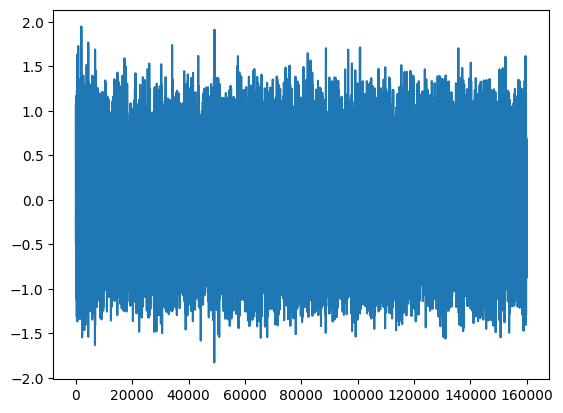

In [26]:
sample_song(ldm, 1, 10)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [12:41<00:00,  1.31it/s]


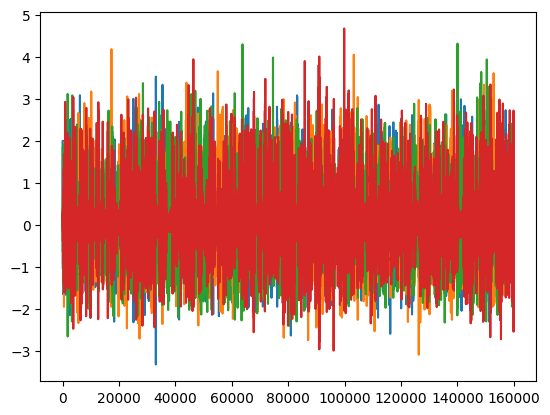

In [15]:
sample_song(ldm, 4, 10)

0.6447406


0.7409319


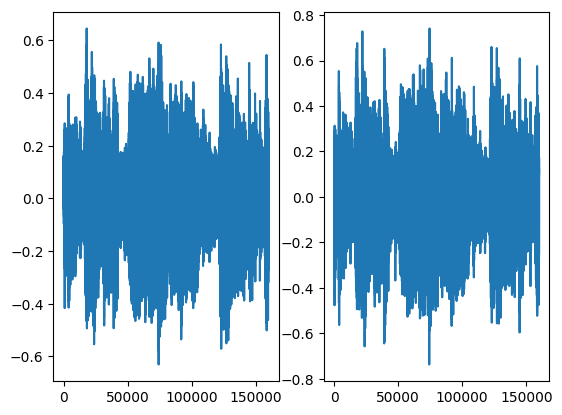

In [22]:
display_idx(1000)